# CS 7324-400B: Lab Six - CNNs

#### Fall 2023
#### Author: Davis Vercher (49377022)

References & Citations
- **Download Link:**
  - https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification
- **Source:**
  - https://www.kaggle.com/gpiosenka

In [62]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.metrics import Accuracy
from tensorflow.keras.metrics import Metric
from keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import MobileNetV2

## 0. Background and use case

### 0a. Business use case

**Task:** create a multi-class classification model that can accurately predict images of cats from ten wildcat species 

**Business purpose/use case:** This model theoritically will be used by wildlife managers globally to automatically identify these wildcats on their camera traps (also known as "trail cameras" by hunters) -- saving time currently required to manually tag camera trap images with the animals contained within individual images. This automated tagging of images containing these predator wildcats will allow wildlife managers to rapdily identify the presence of these animals within their managed wildlife areas in near real-time. In most cases, the presence of native predator wildcats is a sign of a healthy habitat. However, in times of native prey population declines, the presence of these predator wildcats may indicate an increased chance forr extirpation (local extinction) of prey populations. This model will allow wildlife managers to have near real-time insight into the locations/density of predator wildcat species -- a key data point in the succesful management of wildlife areas.

### 0b. Dataset overview

The dataset chosen is an image dataset containing ~230 images per class of 10 separate classes of wildcat species (i.e., African Leopard, Cheetah, Tiger, etc.). Each image is in the shape 224x224x3

I will be training a model to perform multi-class classification.

Figure 1 depicts an example image from the Puma class of the dataset

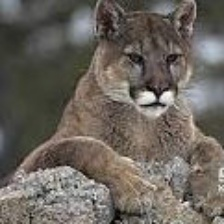

***Figure 1***

Puma

### 0c. Loading the dataset and visualizing an image from each class

In [2]:
ds_path = Path(r'C:\Users\dvercher\Desktop\Lab 6\wildcat_dataset')

In [3]:
images = []
string_labels = []

for class_dir in ds_path.iterdir():
    for img_path in class_dir.iterdir():
        img_bgr = cv2.imread(str(img_path))
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        images.append(img)
        string_labels.append(str(class_dir.name))
        
images = np.array(images)
string_labels = np.array(string_labels)

In [4]:
class_mapping = {
    "AFRICAN LEOPARD": 0,
    "CARACAL": 1,
    "CHEETAH": 2,
    "CLOUDED LEOPARD": 3,
    "JAGUAR": 4,
    "LIONS": 5,
    "OCELOT": 6,
    "PUMA": 7,
    "SNOW LEOPARD": 8,
    "TIGER": 9
}

In [5]:
labels = [class_mapping[label] for label in string_labels]
labels = np.array(labels)

In [6]:
print(len(images)); print(len(labels)); print(len(string_labels))

2339
2339
2339


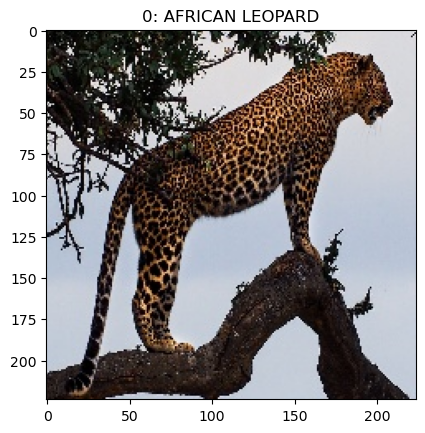

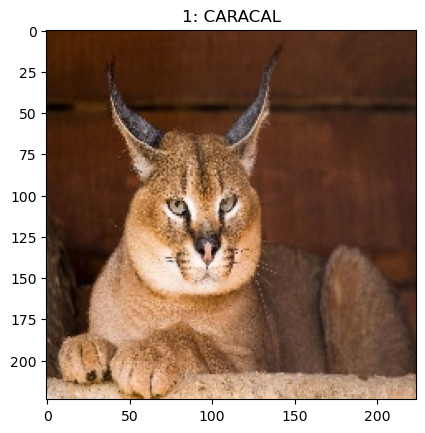

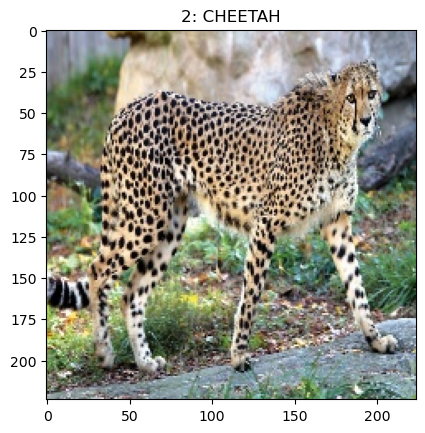

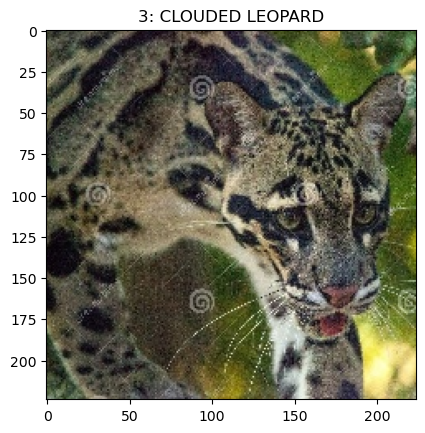

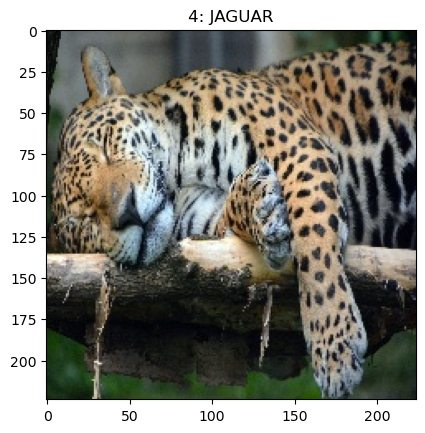

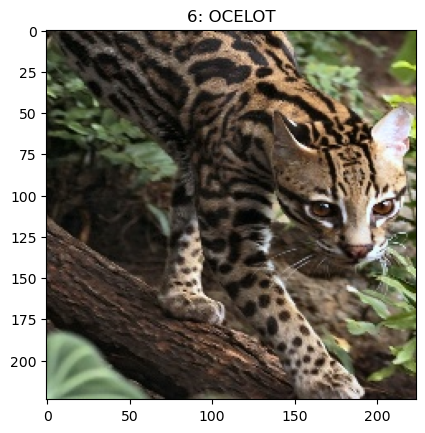

In [7]:
images_display = [0, 236, 472, 707, 936, 1174, 1402, 1635, 1871, 2102]

for i in images_display:
    img = images[i]
    label = str(labels[i]) + ": " + string_labels[i]

    plt.imshow(img)
    plt.title(label)
    plt.show()

## 1. Preparation

### 1a. Metrics choice

**Metric:** Accuracy
- Because my dataset consists of ten very evenly balanced classes (each class contains 230 +- 5 images), my primary metric is accuracy. If my data was not balanced (i.e., one or more class had far more images than the others), accuracy would not be an appropriate primary metric because the model would likely tend toward the dominant class(s).

### 1b. Cross-validation choice

**Method Chosen:** Stratified K-Fold Cross-Validation
- Because my data is already balanced, this method will ensure that the balance is maintained across the train and test sets across folds.
- Additionally, because I need the model to perform well in real-world situations (i.e., in near real-time real-world images from camera traps -- where weather and background image noise will be highly variable) this method will help to ensure the model is consistently identifying target classes correctly without overfitting on the same training data over and over

## 2. Modeling

### 2a. Data expansion using Keras

The following data augmentation techniques will be used to mimic the way these animals will be seen in nature by camera traps:
- **Rotation:** The images will be rotated +/- 20 degrees
- **Width Shift:** simulating the animals being off-center in the camera trap image horizontally
- **Horizontal Flip:** flipping along the vertical axis to simulate the animal walking in the opposite direction of the original image (we will not be flipping vertically because this would simulate "upside-down" animals... something not seen in nature).

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

### 2b. Creating the CNNs

#### 2b1. First model

In [9]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_1.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    all_history.append(history)

    model_1.save('model_1.h5')
    
    scores = model_1.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_1.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 58s 970ms/step - loss: 2.6531 - accuracy: 0.1106 - val_loss: 2.2717 - val_accuracy: 0.1368
Epoch 2/5
59/59 [==============================] - 60s 1s/step - loss: 2.2829 - accuracy: 0.1229 - val_loss: 2.2770 - val_accuracy: 0.1453
Epoch 3/5
59/59 [==============================] - 60s 1s/step - loss: 2.2421 - accuracy: 0.1368 - val_loss: 2.1378 - val_accuracy: 0.1816
Epoch 4/5
59/59 [==============================] - 58s 983ms/step - loss: 2.1765 - accuracy: 0.1807 - val_loss: 2.1200 - val_accuracy: 0.2479
Epoch 5/5
59/59 [==============================] - 65s 1s/step - loss: 2.1638 - accuracy: 0.2154 - val_loss: 2.0421 - val_accuracy: 0.2372
Score for fold 1: accuracy of 23.72%
Epoch 1/5
59/59 [==============================] - 68s 1s/step - loss: 2.1069 - accuracy: 0.2288 - val_loss: 1.9841 - val_accuracy: 0.2799
Epoch 2/5
59/59 [==============================] - 69s 1s/step - loss: 2.0271 - accuracy: 0.2410 - val_loss: 1.8793 - val_a

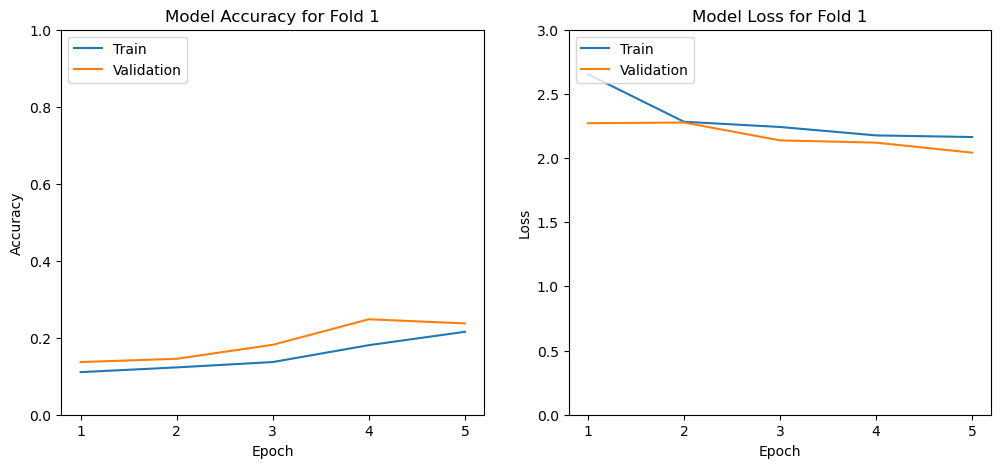

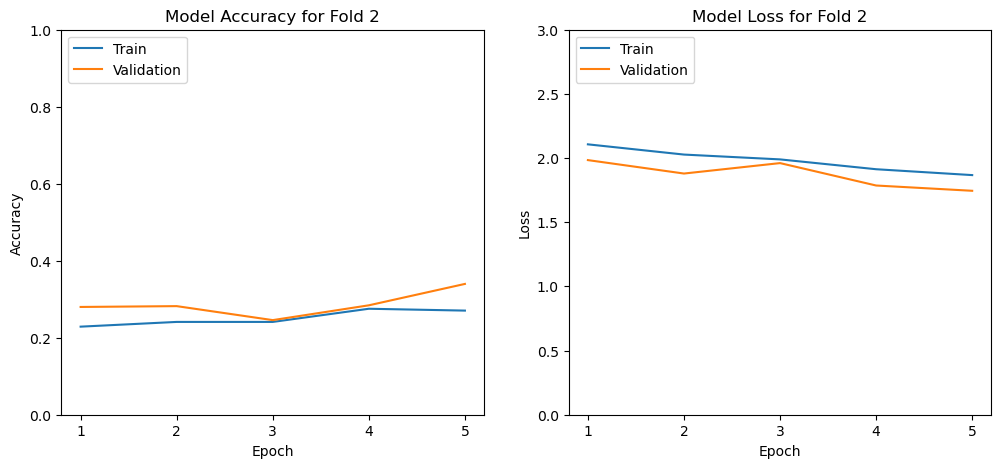

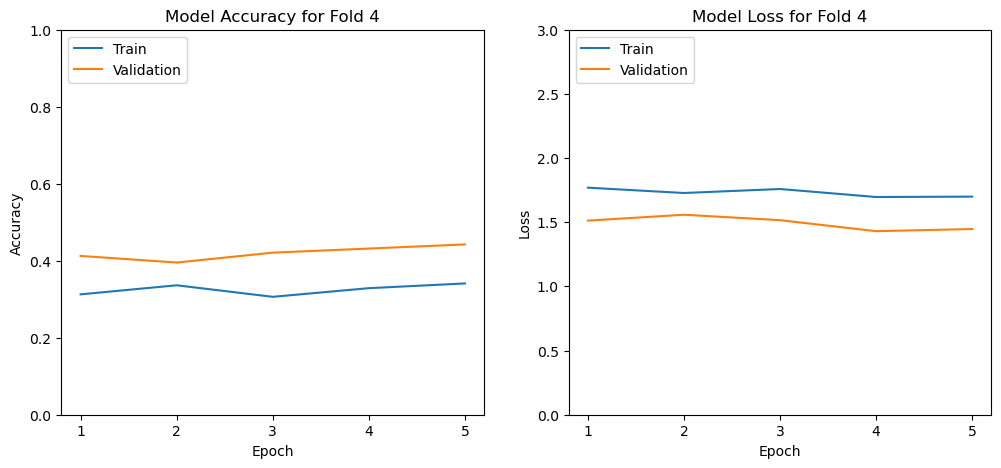

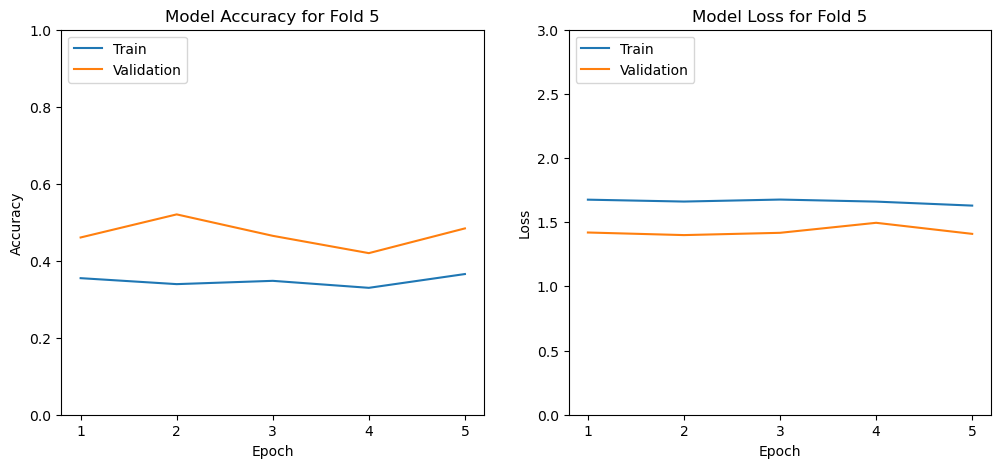

In [13]:
for i, history in enumerate(all_history):
    epochs = range(1, 6)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylim(0, 1)  # Standardize the y-axis for accuracy
    plt.xticks(epochs)  # Set x-axis ticks
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylim(0, 3)
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

#### 2b2. Variant of first model

In [14]:
model_1_variant = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Increased filters
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Increased filters
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_1_variant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

model_1_var_all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_1_variant.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    model_1_var_all_history.append(history)

    model_1_variant.save('model_1_variant.h5')
    
    scores = model_1_variant.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_1_variant.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 126s 2s/step - loss: 2.8931 - accuracy: 0.1245 - val_loss: 2.1799 - val_accuracy: 0.1325
Epoch 2/5
59/59 [==============================] - 121s 2s/step - loss: 2.1969 - accuracy: 0.1593 - val_loss: 2.1432 - val_accuracy: 0.2030
Epoch 3/5
59/59 [==============================] - 123s 2s/step - loss: 2.1755 - accuracy: 0.1807 - val_loss: 2.0997 - val_accuracy: 0.2564
Epoch 4/5
59/59 [==============================] - 116s 2s/step - loss: 2.1212 - accuracy: 0.1962 - val_loss: 2.1003 - val_accuracy: 0.1816
Epoch 5/5
59/59 [==============================] - 122s 2s/step - loss: 2.0644 - accuracy: 0.2250 - val_loss: 1.8959 - val_accuracy: 0.2799
Score for fold 1: accuracy of 27.99%
Epoch 1/5
59/59 [==============================] - 119s 2s/step - loss: 2.0196 - accuracy: 0.2501 - val_loss: 1.8234 - val_accuracy: 0.3291
Epoch 2/5
59/59 [==============================] - 118s 2s/step - loss: 1.9441 - accuracy: 0.2694 - val_loss: 1.8030 - val_

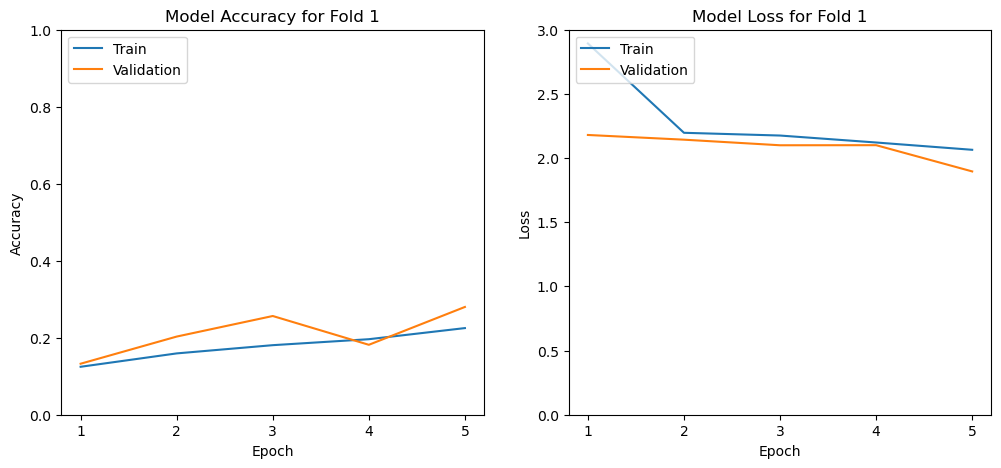

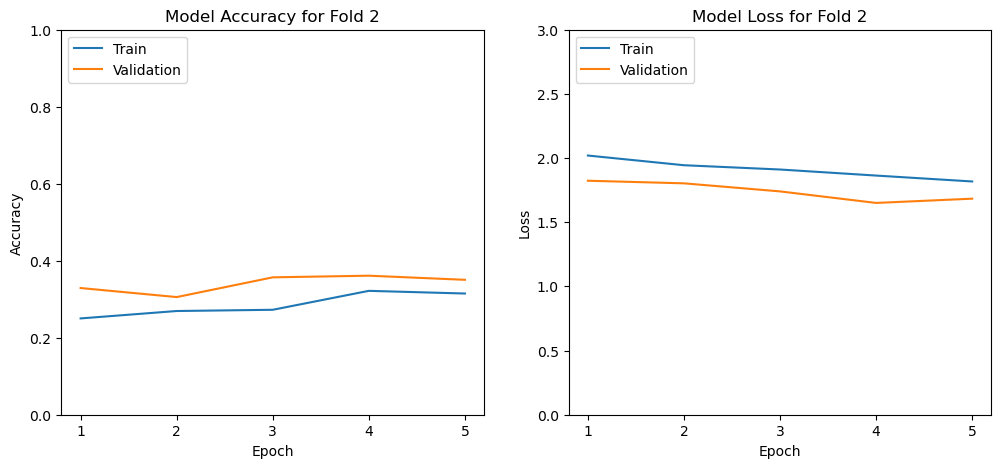

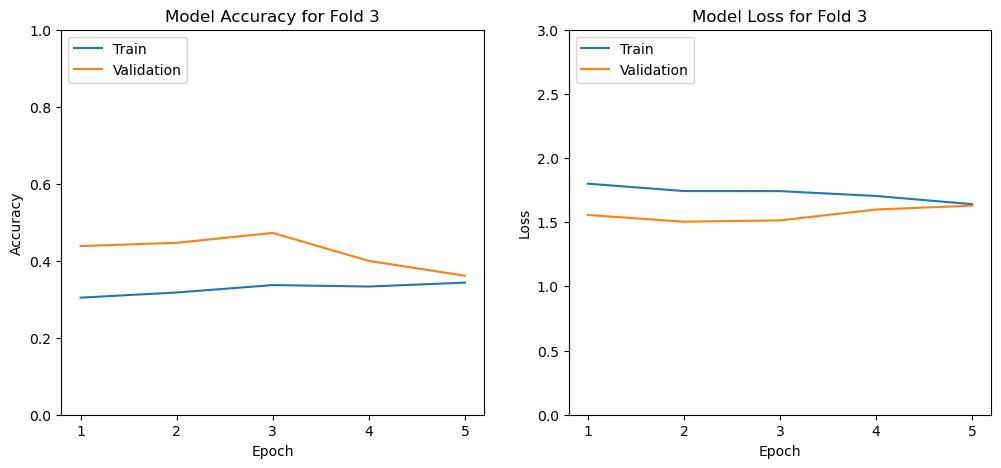

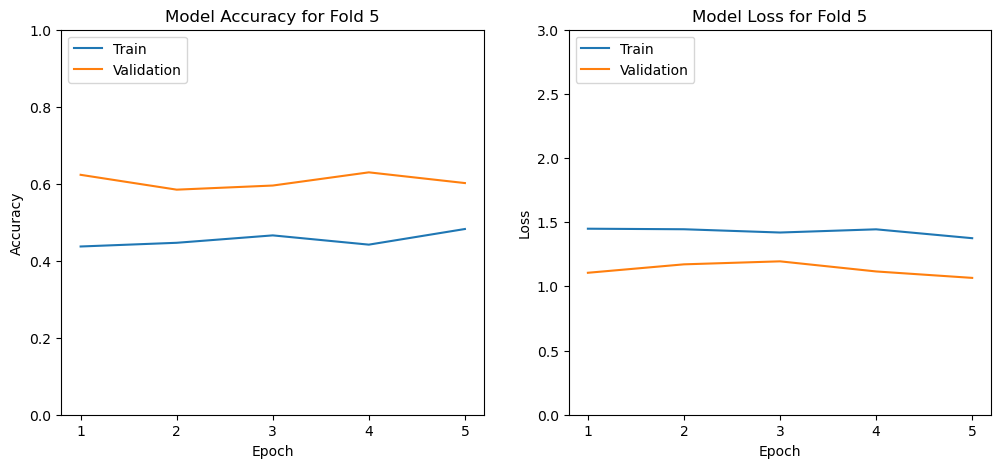

In [18]:
for i, history in enumerate(model_1_var_all_history):
    epochs = range(1, 6)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylim(0, 1)  # Standardize the y-axis for accuracy
    plt.xticks(epochs)  # Set x-axis ticks
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylim(0, 3)
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

#### 2b3. Second model

In [19]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

model_2_all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_2.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    model_2_all_history.append(history)

    model_2.save('model_2.h5')
    
    scores = model_2.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_2.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 67s 1s/step - loss: 2.3627 - accuracy: 0.1149 - val_loss: 2.2343 - val_accuracy: 0.1517
Epoch 2/5
59/59 [==============================] - 67s 1s/step - loss: 2.1932 - accuracy: 0.1742 - val_loss: 2.0593 - val_accuracy: 0.2671
Epoch 3/5
59/59 [==============================] - 66s 1s/step - loss: 2.0336 - accuracy: 0.2373 - val_loss: 1.8477 - val_accuracy: 0.2970
Epoch 4/5
59/59 [==============================] - 70s 1s/step - loss: 1.9681 - accuracy: 0.2485 - val_loss: 1.8505 - val_accuracy: 0.2885
Epoch 5/5
59/59 [==============================] - 66s 1s/step - loss: 1.8489 - accuracy: 0.2822 - val_loss: 1.7121 - val_accuracy: 0.3803
Score for fold 1: accuracy of 38.03%
Epoch 1/5
59/59 [==============================] - 68s 1s/step - loss: 1.8006 - accuracy: 0.2774 - val_loss: 1.6837 - val_accuracy: 0.3932
Epoch 2/5
59/59 [==============================] - 66s 1s/step - loss: 1.8056 - accuracy: 0.2865 - val_loss: 1.6024 - val_accurac

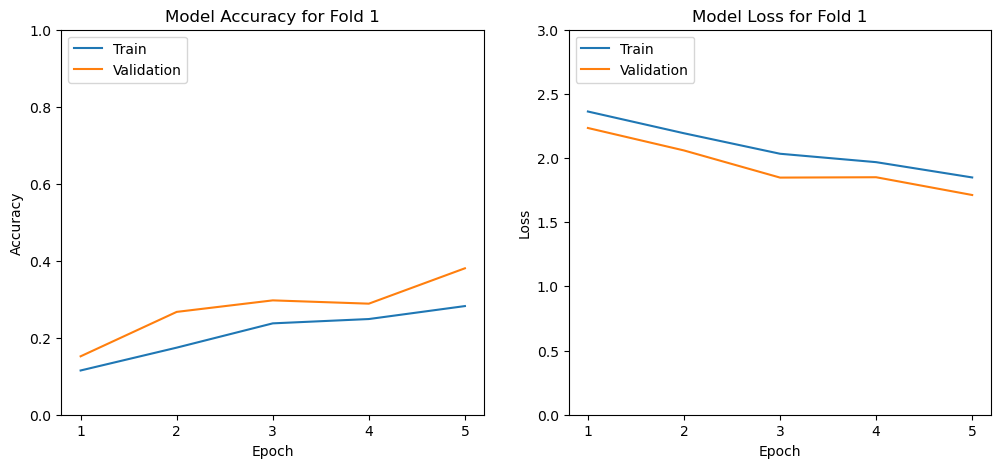

In [26]:
for i, history in enumerate(model_2_all_history):
    epochs = range(1, 6)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylim(0, 1)  # Standardize the y-axis for accuracy
    plt.xticks(epochs)  # Set x-axis ticks
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylim(0, 3)
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

#### 2b4. Variant of second model

In [22]:
model_2_variant = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),  # Changed kernel size
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation='relu'),  # Changed kernel size
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_2_variant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

model_2_var_all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_2_variant.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    model_2_var_all_history.append(history)

    model_2_variant.save('model_2_variant.h5')
    
    scores = model_2_variant.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_2_variant.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 96s 2s/step - loss: 2.3721 - accuracy: 0.1117 - val_loss: 2.2156 - val_accuracy: 0.1560
Epoch 2/5
59/59 [==============================] - 95s 2s/step - loss: 2.1915 - accuracy: 0.1652 - val_loss: 2.0792 - val_accuracy: 0.2991
Epoch 3/5
59/59 [==============================] - 97s 2s/step - loss: 2.0407 - accuracy: 0.2170 - val_loss: 1.7794 - val_accuracy: 0.3333
Epoch 4/5
59/59 [==============================] - 90s 2s/step - loss: 1.9121 - accuracy: 0.2656 - val_loss: 1.7827 - val_accuracy: 0.3141
Epoch 5/5
59/59 [==============================] - 90s 2s/step - loss: 1.8781 - accuracy: 0.2886 - val_loss: 1.6379 - val_accuracy: 0.4359
Score for fold 1: accuracy of 43.59%
Epoch 1/5
59/59 [==============================] - 97s 2s/step - loss: 1.8236 - accuracy: 0.2950 - val_loss: 1.6653 - val_accuracy: 0.3632
Epoch 2/5
59/59 [==============================] - 92s 2s/step - loss: 1.7505 - accuracy: 0.3303 - val_loss: 1.5680 - val_accurac

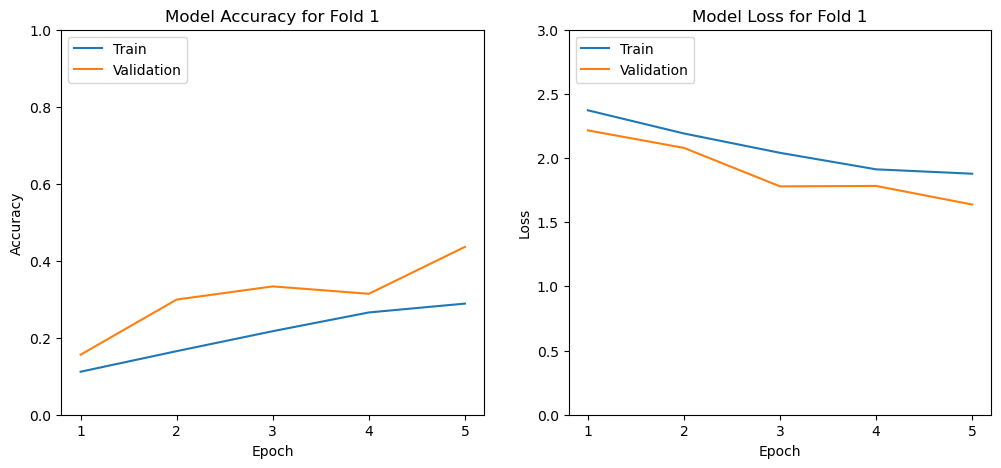

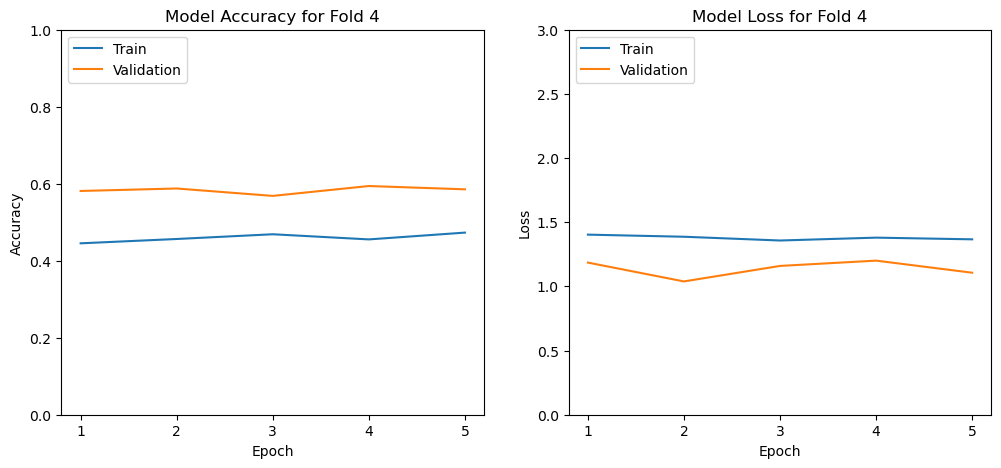

In [27]:
for i, history in enumerate(model_2_var_all_history):
    epochs = range(1, 6)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylim(0, 1)  # Standardize the y-axis for accuracy
    plt.xticks(epochs)  # Set x-axis ticks
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylim(0, 3)
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

### 2c. Compare CNNs

Here I will be testing the performance of each model against a small holdout test set from the original Kaggle dataset. Each class has 5 images that were not in the training set. I will be using accuracy again.

In [9]:
test_path = Path(r'C:\Users\dvercher\Desktop\Lab 6\test')

In [10]:
test_images = []
test_string_labels = []

for class_dir in test_path.iterdir():
    for img_path in class_dir.iterdir():
        img_bgr = cv2.imread(str(img_path))
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        test_images.append(img)
        test_string_labels.append(str(class_dir.name))
        
test_images = np.array(test_images)
test_string_labels = np.array(test_string_labels)

In [11]:
test_labels = [class_mapping[label] for label in test_string_labels]
test_labels = np.array(test_labels)

In [12]:
print(len(test_images)); print(len(test_labels)); print(len(test_string_labels))

50
50
50


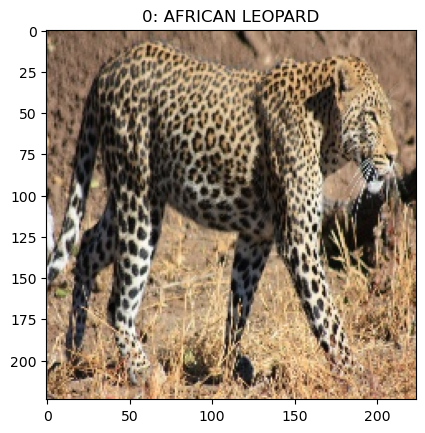

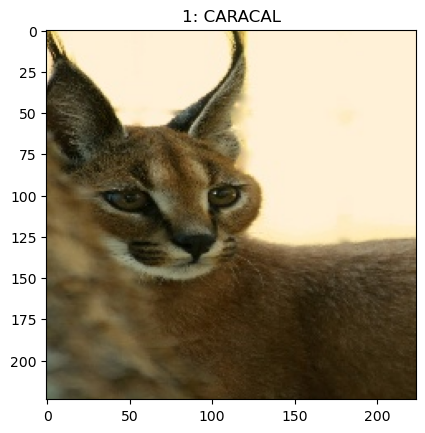

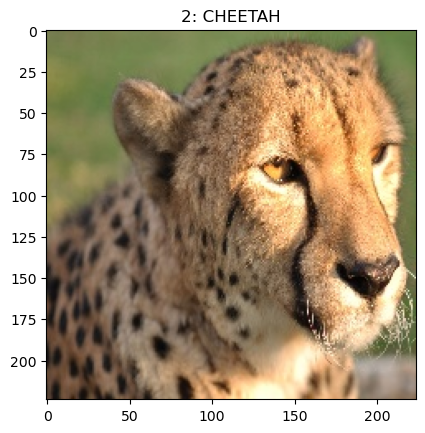

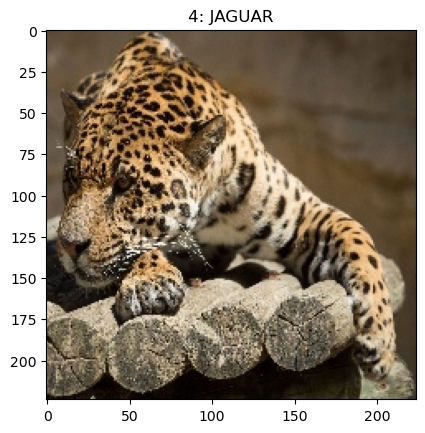

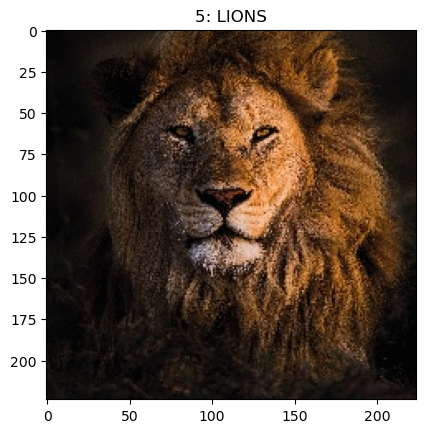

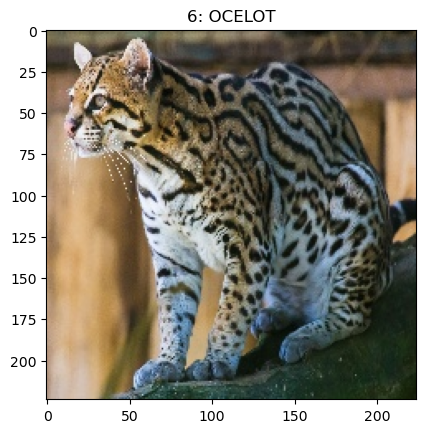

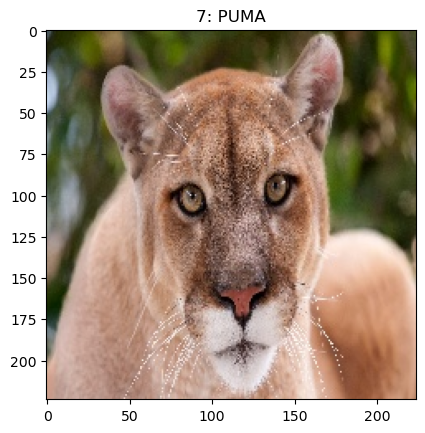

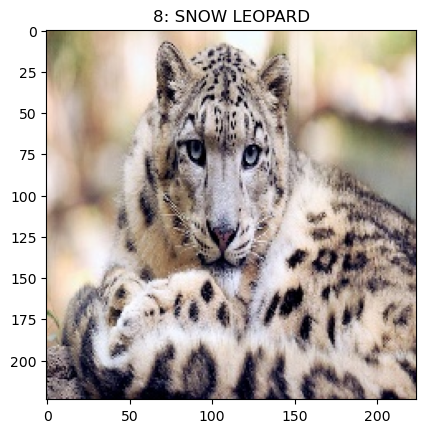

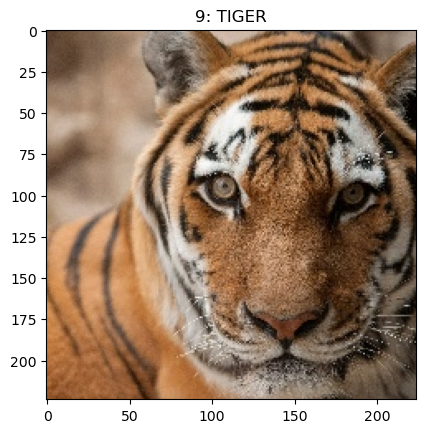

In [13]:
test_images_display = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

for i in test_images_display:
    img = test_images[i]
    label = str(test_labels[i]) + ": " + test_string_labels[i]

    plt.imshow(img)
    plt.title(label)
    plt.show()

In [29]:
models = ['model_1.h5', 'model_1_variant.h5', 'model_2.h5', 'model_2_variant.h5']
predictions = {}
accuracies = {}

for h5 in models:
    model = load_model(h5)
    prediction = model.predict(test_images)
    predicted_classes = np.argmax(prediction, axis=1)
    predictions[h5] = predicted_classes
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    accuracies[h5] = (accuracy * 100).astype(int)
    print(f"Accuracy for {h5}: {accuracy * 100:.1f}%")

2/2 [==============================] - 0s 105ms/step
Accuracy for model_1.h5: 28.0%
2/2 [==============================] - 1s 267ms/step
Accuracy for model_1_variant.h5: 44.0%
2/2 [==============================] - 0s 115ms/step
Accuracy for model_2.h5: 48.0%
2/2 [==============================] - 0s 161ms/step
Accuracy for model_2_variant.h5: 56.0%


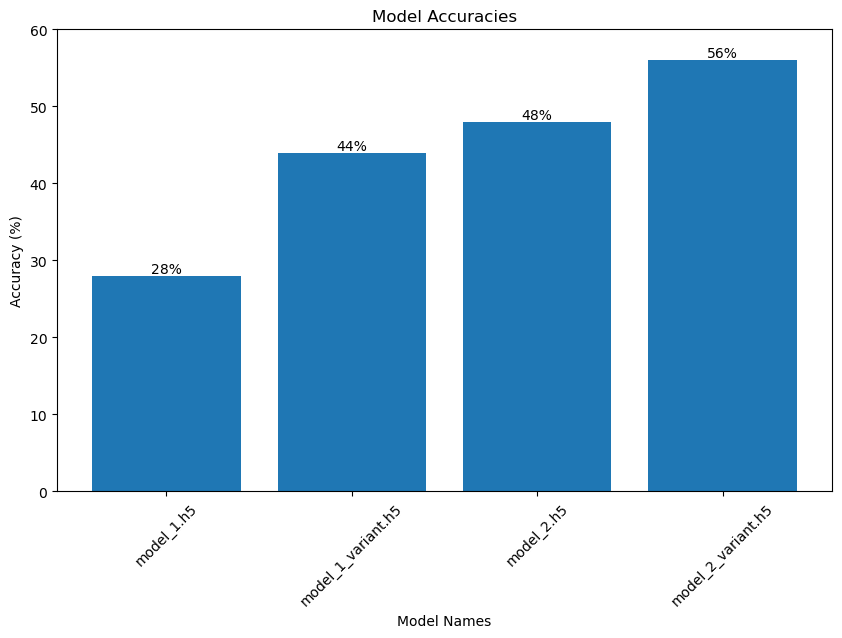

In [36]:
model_names = list(accuracies.keys())
accuracy_numbers = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_numbers)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{round(bar.get_height())}%", va='bottom', ha='center')

plt.xlabel('Model Names')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.show()

The final model ('model_2_variant') performed the best of the four on the holdout test set from the original Kaggle dataset.

However, 56% is not a great performance.

### 2d. Comparision to modern MLP

#### 2d1. Training the MLP

In [72]:
model_mlp = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

mlp_all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_mlp.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    mlp_all_history.append(history)

    model_mlp.save('model_mlp.h5')
    
    scores = model_mlp.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_mlp.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 18s 293ms/step - loss: 16.6288 - accuracy: 0.1203 - val_loss: 5.6775 - val_accuracy: 0.1816
Epoch 2/5
59/59 [==============================] - 18s 298ms/step - loss: 4.9917 - accuracy: 0.1363 - val_loss: 6.1050 - val_accuracy: 0.1517
Epoch 3/5
59/59 [==============================] - 18s 303ms/step - loss: 6.5739 - accuracy: 0.1406 - val_loss: 4.2351 - val_accuracy: 0.1581
Epoch 4/5
59/59 [==============================] - 18s 297ms/step - loss: 5.0389 - accuracy: 0.1571 - val_loss: 4.6008 - val_accuracy: 0.1709
Epoch 5/5
59/59 [==============================] - 18s 298ms/step - loss: 5.0338 - accuracy: 0.1352 - val_loss: 3.3723 - val_accuracy: 0.1731
Score for fold 1: accuracy of 17.31%
Epoch 1/5
59/59 [==============================] - 18s 300ms/step - loss: 4.0076 - accuracy: 0.1571 - val_loss: 3.6887 - val_accuracy: 0.1816
Epoch 2/5
59/59 [==============================] - 18s 310ms/step - loss: 3.4591 - accuracy: 0.1635 - val_loss

#### 2d2. Comparing accuracies of best CNN vs. MLP

In [37]:
models = ['model_2_variant.h5', 'model_mlp.h5']
predictions = {}
accuracies = {}

for h5 in models:
    model = load_model(h5)
    prediction = model.predict(test_images)
    predicted_classes = np.argmax(prediction, axis=1)
    predictions[h5] = predicted_classes
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    accuracies[h5] = (accuracy * 100).astype(int)
    print(f"Accuracy for {h5}: {accuracy * 100:.1f}%")

2/2 [==============================] - 0s 141ms/step
Accuracy for model_2_variant.h5: 56.0%
2/2 [==============================] - 0s 32ms/step
Accuracy for model_mlp.h5: 22.0%


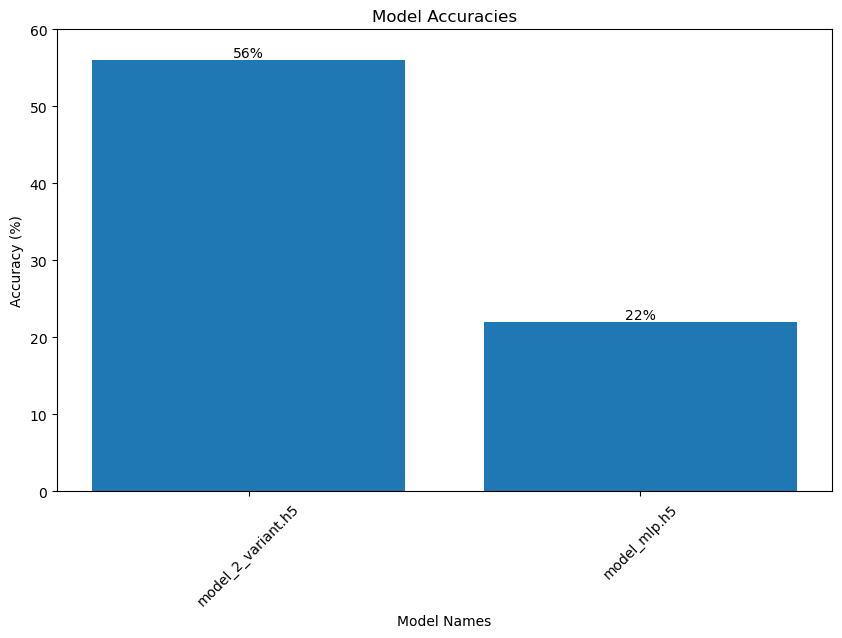

In [38]:
model_names = list(accuracies.keys())
accuracy_numbers = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_numbers)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{round(bar.get_height())}%", va='bottom', ha='center')

plt.xlabel('Model Names')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.show()

#### 2d3. Comparing using ROC/AUC

I am not entirely sure how to do this for multi-class problems, so I am using ChatGPT-4 for this section.

Conversastion: https://chat.openai.com/share/583244ee-1c54-4459-82a9-db06c86ce9b3

In [49]:
cnn_model = load_model('model_2_variant.h5')
mlp_model = load_model('model_mlp.h5')

In [50]:
cnn_predictions = cnn_model.predict(test_images)
mlp_predictions = mlp_model.predict(test_images)

# Binarize the labels
y_test_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

2/2 [==============================] - 0s 21ms/step


In [51]:
# Function to calculate ROC and AUC
def calculate_roc_auc(predictions, y_true):
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

In [52]:
# Calculate for both models
cnn_fpr, cnn_tpr, cnn_roc_auc = calculate_roc_auc(cnn_predictions, y_test_binarized)
mlp_fpr, mlp_tpr, mlp_roc_auc = calculate_roc_auc(mlp_predictions, y_test_binarized)

In [53]:
def plot_roc_curves(fpr, tpr, roc_auc, model_name):
    plt.figure()
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

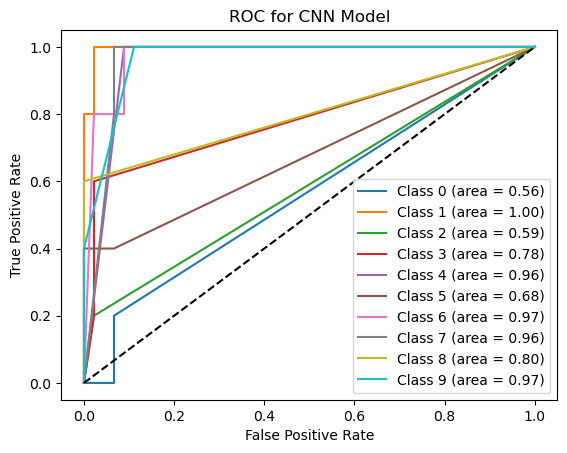

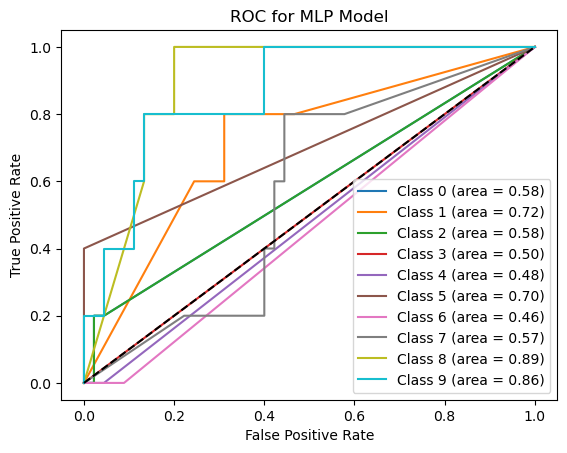

In [55]:
# Plot for both models
plot_roc_curves(cnn_fpr, cnn_tpr, cnn_roc_auc, "CNN Model")
plot_roc_curves(mlp_fpr, mlp_tpr, mlp_roc_auc, "MLP Model")

It appears that not only does the best CNN model have a higher accuracy (seen above), but on average the AUC scores for each class in the CNN model are higher (and much closer to 1) than what is seen in the MLP model. This means that the CNN model is in general performing better (more true positives compared to false positivies).

## 3. Additional work

### 3a. Transfer learning model compared to best CNN above

#### 3a1. Training the transfer learning model

I am going to use MobileNet (v2) as my base model since it was trained on ImageNet (and is therefore suited to image classification).

In [72]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model_transfer_learning = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_transfer_learning.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_no = 1

model_transfer_learning_all_history = []

for train_index, test_index in skf.split(images, labels):

    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)


    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    validation_generator = validation_datagen.flow(X_test, y_test, batch_size=32)


    history = model_transfer_learning.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator
    )

    model_transfer_learning_all_history.append(history)

    model_transfer_learning.save('model_transfer_learning.h5')
    
    scores = model_transfer_learning.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model_transfer_learning.metrics_names[1]} of {scores[1]*100:.2f}%')
    fold_no += 1

Epoch 1/5
59/59 [==============================] - 50s 803ms/step - loss: 1.3839 - accuracy: 0.5387 - val_loss: 0.4819 - val_accuracy: 0.8761
Epoch 2/5
59/59 [==============================] - 44s 745ms/step - loss: 0.6691 - accuracy: 0.7814 - val_loss: 0.3161 - val_accuracy: 0.9060
Epoch 3/5
59/59 [==============================] - 44s 752ms/step - loss: 0.5047 - accuracy: 0.8407 - val_loss: 0.2553 - val_accuracy: 0.9252
Epoch 4/5
59/59 [==============================] - 47s 804ms/step - loss: 0.4512 - accuracy: 0.8557 - val_loss: 0.2223 - val_accuracy: 0.9252
Epoch 5/5
59/59 [==============================] - 44s 752ms/step - loss: 0.4003 - accuracy: 0.8664 - val_loss: 0.1984 - val_accuracy: 0.9423
Score for fold 1: accuracy of 94.23%
Epoch 1/5
59/59 [==============================] - 45s 769ms/step - loss: 0.3749 - accuracy: 0.8771 - val_loss: 0.1686 - val_accuracy: 0.9530
Epoch 2/5
59/59 [==============================] - 45s 761ms/step - loss: 0.3430 - accuracy: 0.8888 - val_loss:

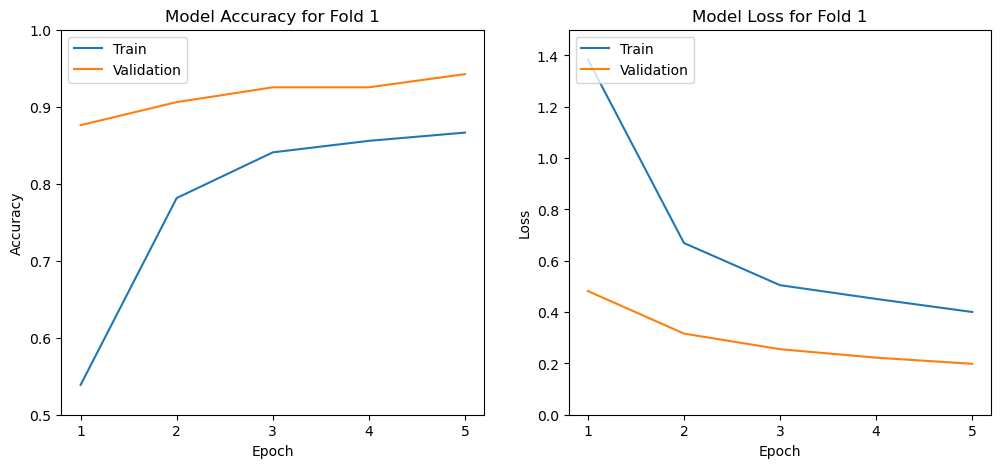

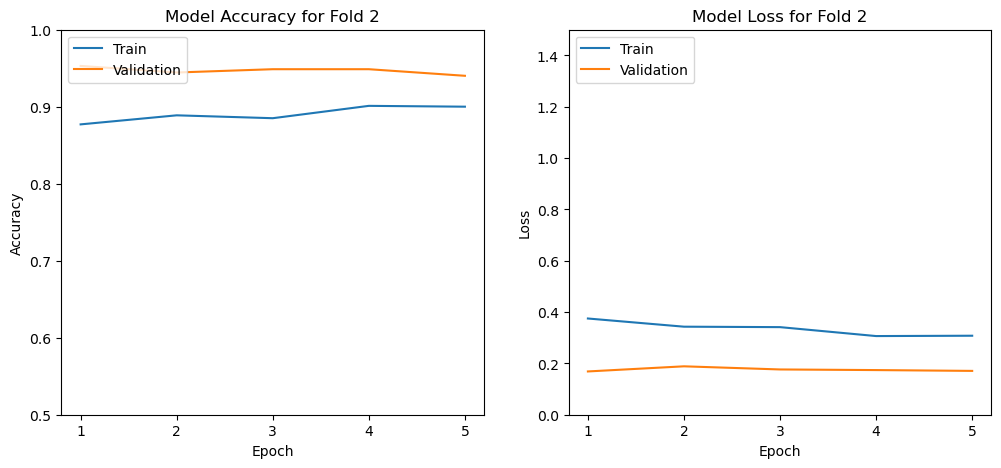

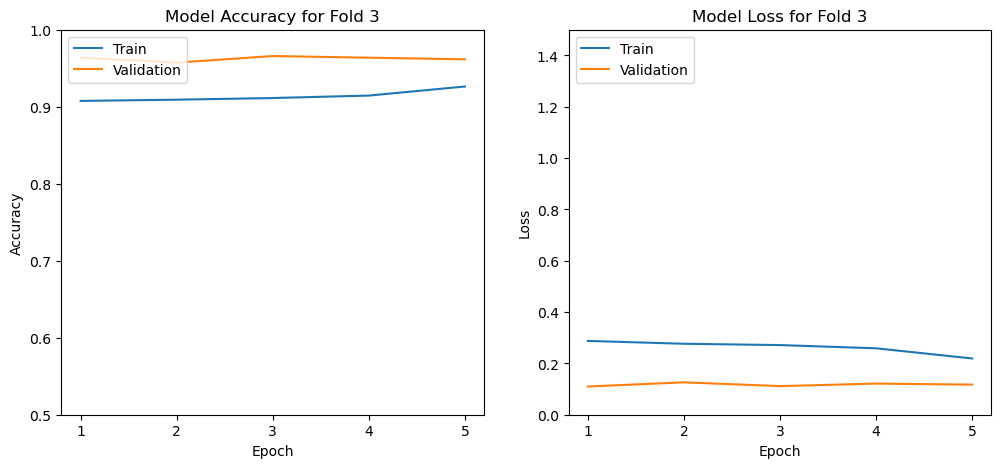

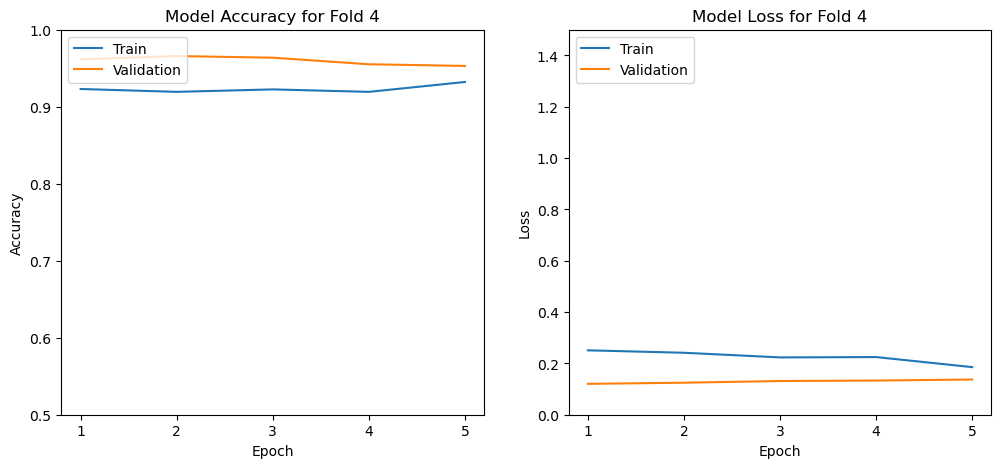

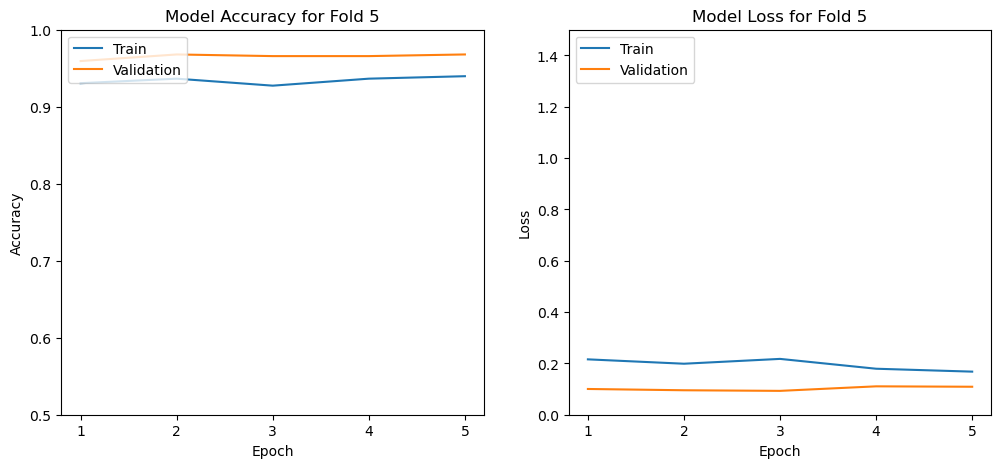

In [69]:
for i, history in enumerate(model_transfer_learning_all_history):
    epochs = range(1, 6)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'Model Accuracy for Fold {i+1}')
    plt.ylim(.5, 1)  # Standardize the y-axis for accuracy
    plt.xticks(epochs)  # Set x-axis ticks
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'Model Loss for Fold {i+1}')
    plt.ylim(0, 1.5)
    plt.xticks(epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

After training the transfer learning model, I see that it performed far better than any of my previous models on the training/validation data. 

Next I will see how it performs on the test images and compare to my best CNN model.

#### 3a2. Comparing the accuracy of the transfer learning model and the best CNN model.

In [84]:
models = ['model_2_variant.h5', 'model_transfer_learning.h5']
predictions = {}
accuracies = {}

for h5 in models:
    model = load_model(h5)
    prediction = model.predict(test_images)
    predicted_classes = np.argmax(prediction, axis=1)
    predictions[h5] = predicted_classes
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    accuracies[h5] = (accuracy * 100).astype(int)
    print(f"Accuracy for {h5}: {accuracy * 100:.1f}%")

2/2 [==============================] - 1s 168ms/step
Accuracy for model_2_variant.h5: 56.0%
2/2 [==============================] - 2s 363ms/step
Accuracy for model_transfer_learning.h5: 6.0%


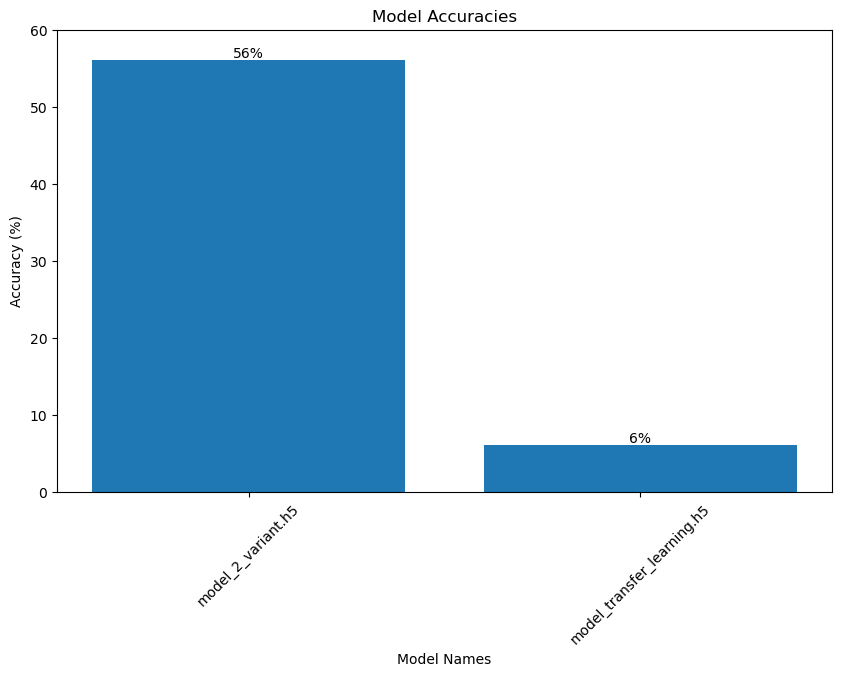

In [85]:
model_names = list(accuracies.keys())
accuracy_numbers = list(accuracies.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_numbers)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{round(bar.get_height())}%", va='bottom', ha='center')

plt.xlabel('Model Names')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.ylim(0, 60)
plt.xticks(rotation=45)
plt.show()

Now I can see that even though my transfer learning model was performing very well on the training/validation data, it massively underperformed on the actual test images. This leads me to believe that my transfer learning model is overfitting.